# NEURAL NETWORKS AND DEEP LEARNING PROJECT

---
A.A. 2023/24 (6 CFU) - Giuseppe Labate, Sana Amiri
---

## Project 1 - Car classification, attribute prediction and car verification

In this project

1.   **Classification** car images given cars dataset CompCars.

2.   **Attributes prediction** based on the images.  
        Attributes for this project are:  
    1. Explicit Attributes:  
    	1. Number of doors  
    	2. Number of seats  
    	3. Type of car  
	2. Implicit Attributes:  
    	4. Max speed  
    	5. Displacement  


In [1]:
# from google.colab import drive
import os

# drive.mount('/content/drive')
# data = '/content/drive/My Drive/Deep_Project/data'

In [2]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
# %matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')  # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
# sns.set()  ---> Uncomment if you want to use seaborn themes

## tqdm for loading bars
from tqdm.notebook import tqdm
import os
import random
## NumPy
import numpy as np
## PyTorch
import torch
import torch.nn as nnpo
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import scipy.io
import time
from torch.autograd import Variable

## Torchvision
import torchvision   # For Computer Vision tasks
from torchvision import transforms   # Transforms for images for data augmentation


# Path to the folder where the datasets are/should be downloaded
DATA_PATH = os.path.join(".", "Deep_Project", "data")  # Change this path to your desired location

NUM_WORKERS = 0 #os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
generator = torch.Generator().manual_seed(seed) # For explicit splitting and/or shuffling

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cuda:0
Number of workers: 0


<Figure size 640x480 with 0 Axes>

In the next code snippet, we will perform DataLoading of the dataset contained in `./Deep_Project/data`. The dataset will be split according to the splitting files located in the `train_test_split` folder.

FROM HERE THE CODE IS USED TO CROP THE DATASET AND LOAD IT CORRECTLY WITH THE RIGHT LABEL


In [4]:
####MODIFICA ALLA FUNZIONE SAVE_CROP_IMAGES###
#HERE THE FUNCTION HAS TO SAVE THE IMAGES IN THE FOLDER CROPPED_IMAGES/DIRECTORY OF THE FULL IMAGE
#FOR EXAMPLE, IF THE FULL IMAGE IS IN THE FOLDER "image/AM General Hummer SUV 2000" THE CROPPED IMAGE HAS TO BE SAVED IN "cropped_images/classification/train/AM General Hummer SUV 2000"
#WE WANT ALSO TO DO IT WITHOUT USING CROPDATASET FUNCTION

from PIL import Image
import torchvision.transforms as transforms

# Path to the folder where the datasets are/should be downloaded
image_dir = os.path.join(DATA_PATH, "image")
label_dir = os.path.join(DATA_PATH, "label")
train_list = os.path.join(DATA_PATH, "train_test_split", "classification", "train.txt")
test_list = os.path.join(DATA_PATH, "train_test_split", "classification", "test.txt")

def crop_image(image, bbox):
	x1, y1, x2, y2 = bbox
	image_np = np.array(image)
	return image_np[y1:y2, x1:x2]

#Loads the viewpoint and bounding box from the label file
def load_label(label_path):
	with open(label_path, 'r') as f:
		lines = f.readlines()
		viewpoint = int(lines[0].strip())
		bbox = list(map(int, lines[2].strip().split()))
	return viewpoint, bbox

def save_cropped_images(file_list, output_dir):
	# Create the output directory if it does not exist
	if not os.path.exists(output_dir):
		os.makedirs(output_dir)

		# Access to the image paths and labels
		with open(file_list, 'r') as f:
			for line in tqdm(f, desc="Saving images"):
				image_path = os.path.join(image_dir, line.strip())
				label_path = os.path.join(label_dir, line.strip()).replace('.jpg', '.txt')
				car_properties = load_label(label_path)
				# Dividing the label path into car make, model and year
				label_path_parts = line.strip().split('/')

				# Given the values of labels path, put the correct car make, model and year in the output directory
				output_image_dir = os.path.join(output_dir, label_path_parts[0], label_path_parts[1], label_path_parts[2])
				os.makedirs(output_image_dir, exist_ok=True)

				# Load the image
				image = Image.open(image_path).convert("RGB")

				# Crop the image
				cropped_image = crop_image(image, car_properties[1])
				cropped_image = transforms.ToPILImage()(cropped_image)

				# Save the cropped image
				output_image_path = os.path.join(output_image_dir, os.path.basename(image_path))
				cropped_image.save(output_image_path)

def get_names(mat_file, labels):
	# Load the make and model names from the .mat file
	mat_data = scipy.io.loadmat(mat_file)
	make_names = mat_data['make_names']
	model_names = mat_data['model_names']
	make_name = make_names[int(labels[0]) - 1][0].item()
	model_name = model_names[int(labels[1]) - 1][0].item()
	return make_name, model_name

# Example usage
output_dir = os.path.join(DATA_PATH, "cropped_image", "classification")
train_path = os.path.join(output_dir, "train")

test_path = os.path.join(output_dir, "test")
print("test", test_path)
print("train", train_path)
save_cropped_images(train_list, train_path)
save_cropped_images(test_list, test_path)


test .\Deep_Project\data\cropped_image\classification\test
train .\Deep_Project\data\cropped_image\classification\train


In [5]:
#### DATA LOADER FOR CROPPED IMAGES ####
from torch.utils.data import Dataset, DataLoader

class CroppedCarDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

		# Save the images contained in image_dir
        self.image_paths = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".jpg"):
                    self.image_paths.append(os.path.join(root, file))

		# Save the labels
        self.car_make = []
        self.car_model = []
        for image_path in self.image_paths:
            label = image_path.split(os.sep)[-4:-1]  # Car make, model, year
            #Get labels from the image path, append them to the lists, and convert them to tensors of type long
            self.car_make.append(int(label[0]))
            self.car_model.append(int(label[1]))

		# # Load the make and model names from the .mat file
        # mat_data = scipy.io.loadmat(mat_file)
        # self.make_names = mat_data['make_names']
        # self.model_names = mat_data['model_names']

	#Returns the image, viewpoint, bounding box and label path
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")

        # make_name = self.make_names[int(labels[0]) - 1][0].item()
        # model_name = self.model_names[int(labels[1]) - 1][0].item()
        # year = labels[2]

        #label = [make_name, model_name, year]
        car_make = self.car_make[index]
        car_model = self.car_model[index]

        if self.transform:
            image = self.transform(image)

        return image, car_make, car_model

    def __len__(self):
        return len(self.image_paths)

print("Data loading is complete.")



Data loading is complete.


### Calculating the mean and std

In [1]:
def calculate_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _, _ in loader:  # Assume the dataset returns (image, label)
        # Convert images to float tensors
        images = images.float()
        batch_samples = images.size(0)  # Number of images in the batch
        total_samples += batch_samples

        # Calculate mean and sum of squares per channel
        mean += images.mean(dim=[0, 2, 3]) * batch_samples
        std += images.std(dim=[0, 2, 3]) * batch_samples

    mean /= total_samples
    std /= total_samples

    return mean, std

# Create the dataset
to_tensor_train = transforms.Compose([
	transforms.ToTensor()
])
train_val_dataset_denorm = CroppedCarDataset(train_path, transform=to_tensor_train)
train_len = int(0.7*len(train_val_dataset_denorm))  # 70% training
val_len = len(train_val_dataset_denorm) - train_len	# 30% validation

# Split the dataset into training and validation sets
# Set the seed for reproducibility so that the split is the same every time
train_dataset_denorm, _ = torch.utils.data.random_split(train_val_dataset_denorm, [train_len, val_len], generator=generator)

# Calculate the mean and standard deviation of the training dataset
mean, std = calculate_mean_std(train_dataset_denorm)

print("Mean:", mean)
print("Std:", std)

NameError: name 'transforms' is not defined

In the following cell, I will create a transformation composition that will be applied to the images in our dataset. This transformation is crucial for preprocessing the images before they are fed into our machine learning model. The preprocessing steps may include operations such as resizing, normalization, augmentation, and other techniques to enhance the quality and variability of the training data. By applying these transformations, we aim to improve the model's performance and generalization capabilities. Let's proceed with defining this transformation function in the next cell.

In [ ]:
from torchvision.transforms import RandomAffine, RandomHorizontalFlip, RandomVerticalFlip

transform1 = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	RandomAffine((0.05, 0.05)),
  	RandomHorizontalFlip(),
  	RandomVerticalFlip(),
    transforms.CenterCrop(224),
	transforms.Normalize(mean, std),
])

transform2 = transforms.Compose([
				transforms.Normalize(mean, std),
                transforms.RandomRotation(10),
                transforms.Scale(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
				])


transform3 = transforms.Compose([
	transforms.Resize((299, 299)),  # Inception v3 requires 299x299 input size
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# Path to the folder where the datasets are/should be downloaded
class_dir = os.path.join(DATA_PATH, "cropped_image", "classification")
train_dir = os.path.join(class_dir, "train")
test_dir = os.path.join(class_dir, "test")
mat_file = os.path.join(DATA_PATH, "misc" ,"make_model_name.mat")

# Create the datasets
train_val_dataset = CroppedCarDataset(image_dir=train_dir, transform=transform1) #dataset that contains train and validation datasets

train_dataset, val_dataset = data.random_split(train_val_dataset, [train_len, val_len])

test_dataset = CroppedCarDataset(image_dir=test_dir, transform=transform1, generator = generator)   #dataset that contains test dataset


# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

In [7]:
# ############################################################
# # Function to count the number of images per car make
# ############################################################

# from collections import Counter
# def count_labels(dataset, make = True):
# 	# Extracts the labels from the dataset
# 	if make:
# 		list = [make for _, make, _ in dataset]
# 	else:
# 		list = [model for _, _, model in dataset]

# 	# Counts the occurrences of each label
# 	dataset_count = Counter(list)

# 	# Transform the labels into the string using get_names function
# 	if make:
# 		dataset_count_strings = {tuple(get_names(mat_file, [label, 0]))[0]: count for label, count in dataset_count.items()}
# 	else:
# 		dataset_count_strings = {tuple(get_names(mat_file, [0, label]))[1]: count for label, count in dataset_count.items()}

# 	# Print the labels and their counts
# 	print("Dataset labels:", dataset_count_strings)

# 	# Sort the labels by alphabetical order
# 	sorted_labels = sorted(dataset_count_strings.items(), key=lambda x: x[0])
# 	labels, counts = zip(*sorted_labels)

# 	# Create the plot
# 	plt.figure(figsize=(15, 5))
# 	plt.bar(labels, counts)
# 	plt.xticks(rotation=90)
# 	plt.ylabel("Number of images")
# 	plt.title("Number of images per car make in the training dataset")
# 	plt.show()

# 	return dataset_count_strings



# train_counts = count_labels(train_dataset)
# val_counts = count_labels(val_dataset)
# test_counts = count_labels(test_dataset)

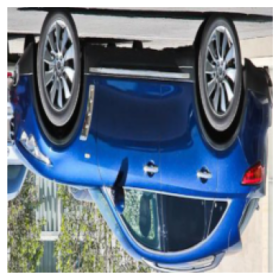

Make: 131
Model: 1015
0
torch.Size([32, 3, 224, 224])
tensor([140,  97,  77, 122,  73,  73,  54, 114,  97, 122,  11, 122,  73, 131,
        155, 111,  95, 102,  81,  92,  78, 118, 100,  77,  81, 150, 158, 140,
         54,  73,  95, 111])
tensor([1185,  856,  127,  593,  440,  441,  192, 1445,  859,  597,  738,  587,
         491, 1010,  814, 1707,  913,  255,  105,  747,   24,  957,  251,  124,
          70,  380, 1258, 1200,  194,  501,  911, 1721])
('Infiniti', 'Infiniti QX70')
Number of images in the training set: 11211
Number of images in the validation set: 4805
Number of images in the test set: 14939
Image shape: torch.Size([3, 224, 224])


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function to denormalize images
def denormalize(img, mean, std):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Denormalize
    return img

# Function to display images
def imshow(img):
    #img = img / 2 + 0.5  # Unnormalize
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display the first 5 images from the training set
# for i in range(5):
#     img, label = train_dataset[i]
#     img = denormalize(img, mean, std)
#     imshow(img)
#     print("Labels:",label)

img, car_make, car_model = val_dataset[2000]
img = denormalize(img.clone(), mean, std)
imshow(img)
print("Make:",car_make)
print("Model:",car_model)


for i, (img_batch, car_make_batch, car_model_batch) in enumerate(train_loader):
	print(i)
	print(img_batch.shape)
	print(car_make_batch)
	print(car_model_batch)
	break

print(get_names(mat_file, [car_make, car_model]))


print("Number of images in the training set:", len(train_dataset))
print("Number of images in the validation set:", len(val_dataset))
print("Number of images in the test set:", len(test_dataset))
print("Image shape:", img.shape)

# Model

Let's create the models we will use.  
In this project we will train and test 3 different models to see which one is better:  
##### 1. ImageNet pretrained Network
##### 2. ResNet50
##### 3. Inception v4

**RestNet50**
The identity block is the standard block used in ResNets, and corresponds to the case where the input activation has the same dimension as the output activation. Here, we implement an identity block in which the skip connection skips over 3 hidden layers.

In [9]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU

class MainPath(Module):

    def __init__(self, in_channels, filters, kernel_size, stride=1):
        super().__init__()
        F1, F2, F3 = filters
        self.main_path = Sequential(
            Conv2d(in_channels, F1, kernel_size=1, stride=stride),
            BatchNorm2d(F1),
            ReLU(),
            Conv2d(F1, F2, kernel_size=kernel_size, padding=kernel_size//2),
            BatchNorm2d(F2),
            ReLU(),
            Conv2d(F2, F3, kernel_size=1),
            BatchNorm2d(F3),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y

class IdentityBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size)
        self.relu = ReLU()

    def forward(self, x):
        y = self.relu(self.main_path(x) + x)
        return y

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up.

In [10]:
class ConvolutionalBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size, stride=2)
        self.relu = ReLU()
        self.shortcut_path = Sequential(
            Conv2d(in_channels, filters[2], kernel_size=1, stride=2),
            BatchNorm2d(filters[2])
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.relu(self.main_path(x) + self.shortcut_path(x))
        return y

**Building the ResNet model (50 layers)**
Below we implement the ResNet50 model.
The input of the Linear layer is the output of the previous layer which we can compute with this formula: O = ((d-F+2p) /s) +1

In [11]:
from torch.nn import MaxPool2d, AvgPool2d, Linear, Dropout
class ResNet50(Module):

    def __init__(self):
        super().__init__()
        self.network = Sequential(
            Conv2d(3, 64, kernel_size=7, stride=2),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=3, stride=2),
            ConvolutionalBlock(64, [64, 64, 256], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(256, [64, 64, 256], kernel_size=3),
            IdentityBlock(256, [64, 64, 256], kernel_size=3),
            ConvolutionalBlock(256, [128, 128, 512], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            ConvolutionalBlock(512, [256, 256, 1024], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            ConvolutionalBlock(1024, [512, 512, 2048], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(2048, [512, 512, 2048], kernel_size=3),
            IdentityBlock(2048, [512, 512, 2048], kernel_size=3),
            AvgPool2d(kernel_size=2, stride=2)
        )
        self.classification_layer = Linear(8192, 163) #163 is the number of classes (car makes) we are classifying in this project
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x).reshape((x.shape[0], -1))
        y = self.classification_layer(y)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from torchmetrics.functional import accuracy

# Assuming the model, train_loader, and val_loader are already defined
model = ResNet50()
opt = Adam(model.parameters(), lr=1e-3, weight_decay=0, betas=(0.9, 0.999))
loss_fn = CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs = 20
best_val = np.inf

checkpoint_path = "model.pt"	# Path to save the model

# Load the model if it exists
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))

# Lists to store the loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []
top1_accuracies = []
top5_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    train_loss = 0
    iterator = tqdm(train_loader)
    for batch_x, batch_y, _ in iterator:  # ignoring the third value with _
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_pred = model(batch_x)

        loss = loss_fn(y_pred, batch_y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.detach().cpu().numpy()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

    train_loss /= len(train_loader)  # Average training loss for the epoch
    train_losses.append(train_loss)
    train_acc = accuracy(preds=y_pred, target=batch_y, task='multiclass', num_classes=163, top_k=1)
    print(f"Average Training loss: {train_loss}")
    print()

    # Validation loop
    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y, _ in tqdm(val_loader):  # ignoring the third value
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)

        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)

        val_loss = loss_fn(predictions, true)
        val_acc = (predictions.argmax(dim=1) == true).float().mean()

        val_losses.append(val_loss.item())
        top1_accu = accuracy(preds=predictions, target=true,task='multiclass',num_classes= 163, top_k=1)
        top5_accu = accuracy(preds=predictions, target=true,task='multiclass',num_classes= 163, top_k=5)
        top1_accuracies.append(top1_accu.item())
        top5_accuracies.append(top5_accu.item())

        print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}, TOP1 accuracy: {top1_accu}, TOP5 accuracy: {top5_accu}")

    # Save the model if the validation loss improves
    if val_loss < best_val:
        print("Saved Model")
        torch.save(model.state_dict(), checkpoint_path)
        best_val = val_loss


C:\Users\giuse\AppData\Local\Temp\ipykernel_49380\2737514130.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Epoch: 1


Train loss: 2.9085588455200195: 100%|██████████| 351/351 [02:20<00:00,  2.51it/s]


Average Training loss: 2.951470677329604


100%|██████████| 151/151 [00:24<00:00,  6.25it/s]


Validation loss: 3.2623648643493652, Validation accuracy: 0.17689906060695648, TOP1 accuracy: 0.17689906060695648, TOP5 accuracy: 0.45598334074020386
Saved Model
Epoch: 2


Train loss: 2.5373945236206055: 100%|██████████| 351/351 [01:22<00:00,  4.23it/s]


Average Training loss: 2.8113553048538686


100%|██████████| 151/151 [00:23<00:00,  6.37it/s]


Validation loss: 3.4734671115875244, Validation accuracy: 0.1877211183309555, TOP1 accuracy: 0.1877211183309555, TOP5 accuracy: 0.4620187282562256
Epoch: 3


Train loss: 3.072497606277466: 100%|██████████| 351/351 [01:23<00:00,  4.22it/s] 


Average Training loss: 2.662710480880194


100%|██████████| 151/151 [00:24<00:00,  6.18it/s]


Validation loss: 3.2654037475585938, Validation accuracy: 0.21269510686397552, TOP1 accuracy: 0.21269510686397552, TOP5 accuracy: 0.4990634620189667
Epoch: 4


Train loss: 3.082888126373291: 100%|██████████| 351/351 [01:23<00:00,  4.21it/s] 


Average Training loss: 2.5676552478404466


100%|██████████| 151/151 [00:21<00:00,  7.07it/s]


Validation loss: 3.1910877227783203, Validation accuracy: 0.23537981510162354, TOP1 accuracy: 0.23537981510162354, TOP5 accuracy: 0.5469302535057068
Saved Model
Epoch: 5


Train loss: 2.6936185359954834: 100%|██████████| 351/351 [01:19<00:00,  4.44it/s]


Average Training loss: 2.393550619100913


100%|██████████| 151/151 [00:21<00:00,  7.01it/s]


Validation loss: 3.8980720043182373, Validation accuracy: 0.23350676894187927, TOP1 accuracy: 0.23350676894187927, TOP5 accuracy: 0.5388137102127075
Epoch: 6


Train loss: 2.078597068786621: 100%|██████████| 351/351 [01:17<00:00,  4.51it/s] 


Average Training loss: 2.2683627605438232


100%|██████████| 151/151 [00:21<00:00,  7.06it/s]


Validation loss: 3.1074604988098145, Validation accuracy: 0.2539021968841553, TOP1 accuracy: 0.2539021968841553, TOP5 accuracy: 0.5579604506492615
Saved Model
Epoch: 7


Train loss: 1.9578967094421387: 100%|██████████| 351/351 [01:23<00:00,  4.21it/s]


Average Training loss: 2.189876618887964


100%|██████████| 151/151 [00:21<00:00,  6.98it/s]


Validation loss: 3.3945703506469727, Validation accuracy: 0.21019770205020905, TOP1 accuracy: 0.21019771695137024, TOP5 accuracy: 0.4951092600822449
Epoch: 8


Train loss: 1.9628013372421265: 100%|██████████| 351/351 [01:18<00:00,  4.48it/s]


Average Training loss: 2.1158477645314315


100%|██████████| 151/151 [00:22<00:00,  6.68it/s]


Validation loss: 2.9609553813934326, Validation accuracy: 0.28470343351364136, TOP1 accuracy: 0.28470343351364136, TOP5 accuracy: 0.5781477689743042
Saved Model
Epoch: 9


Train loss: 2.1801228523254395: 100%|██████████| 351/351 [01:21<00:00,  4.33it/s]


Average Training loss: 1.9505899207204835


100%|██████████| 151/151 [00:22<00:00,  6.85it/s]


Validation loss: 2.9945361614227295, Validation accuracy: 0.2853277921676636, TOP1 accuracy: 0.2853277921676636, TOP5 accuracy: 0.6004162430763245
Epoch: 10


Train loss: 1.8073118925094604: 100%|██████████| 351/351 [01:21<00:00,  4.29it/s]


Average Training loss: 1.7878653514079559


100%|██████████| 151/151 [00:25<00:00,  5.99it/s]


Validation loss: 3.013751745223999, Validation accuracy: 0.29094693064689636, TOP1 accuracy: 0.29094693064689636, TOP5 accuracy: 0.609157145023346
Epoch: 11


Train loss: 2.6109039783477783: 100%|██████████| 351/351 [01:22<00:00,  4.25it/s]


Average Training loss: 1.6594741731627374


100%|██████████| 151/151 [00:21<00:00,  7.02it/s]


Validation loss: 3.540583848953247, Validation accuracy: 0.2859521210193634, TOP1 accuracy: 0.2859521210193634, TOP5 accuracy: 0.6010406017303467
Epoch: 12


Train loss: 0.9862779378890991: 100%|██████████| 351/351 [02:34<00:00,  2.27it/s]


Average Training loss: 1.5488423197357744


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Validation loss: 3.301271438598633, Validation accuracy: 0.3055150806903839, TOP1 accuracy: 0.3055150806903839, TOP5 accuracy: 0.6062434911727905
Epoch: 13


Train loss: 0.9870878458023071: 100%|██████████| 351/351 [03:23<00:00,  1.73it/s]


Average Training loss: 1.3991310384198812


100%|██████████| 151/151 [00:24<00:00,  6.13it/s]


Validation loss: 2.892272710800171, Validation accuracy: 0.3244536817073822, TOP1 accuracy: 0.3244536817073822, TOP5 accuracy: 0.6372528672218323
Saved Model
Epoch: 14


Train loss: 1.5602413415908813: 100%|██████████| 351/351 [04:28<00:00,  1.31it/s]


Average Training loss: 1.2687394405022645


100%|██████████| 151/151 [00:25<00:00,  6.02it/s]


Validation loss: 2.846114158630371, Validation accuracy: 0.3344433009624481, TOP1 accuracy: 0.3344433009624481, TOP5 accuracy: 0.6397502422332764
Saved Model
Epoch: 15


Train loss: 1.6747856140136719: 100%|██████████| 351/351 [01:25<00:00,  4.09it/s]


Average Training loss: 1.1664492056580351


100%|██████████| 151/151 [00:21<00:00,  7.11it/s]


Validation loss: 2.915823459625244, Validation accuracy: 0.34693026542663574, TOP1 accuracy: 0.34693029522895813, TOP5 accuracy: 0.6495317220687866
Epoch: 16


Train loss: 1.3900055885314941: 100%|██████████| 351/351 [01:20<00:00,  4.34it/s]


Average Training loss: 1.0849622182357006


100%|██████████| 151/151 [00:25<00:00,  5.86it/s]


Validation loss: 3.56374454498291, Validation accuracy: 0.33985432982444763, TOP1 accuracy: 0.33985432982444763, TOP5 accuracy: 0.6391258835792542
Epoch: 17


Train loss: 0.907396674156189: 100%|██████████| 351/351 [01:22<00:00,  4.26it/s]  


Average Training loss: 0.9828156322410643


100%|██████████| 151/151 [00:21<00:00,  7.14it/s]


Validation loss: 3.0204951763153076, Validation accuracy: 0.350468248128891, TOP1 accuracy: 0.350468248128891, TOP5 accuracy: 0.6697190403938293
Epoch: 18


Train loss: 0.6369082927703857: 100%|██████████| 351/351 [01:23<00:00,  4.20it/s] 


Average Training loss: 0.8805014080131836


100%|██████████| 151/151 [00:25<00:00,  5.95it/s]


Validation loss: 2.9399220943450928, Validation accuracy: 0.37273672223091125, TOP1 accuracy: 0.37273672223091125, TOP5 accuracy: 0.6722164154052734
Epoch: 19


Train loss: 1.0623042583465576: 100%|██████████| 351/351 [01:19<00:00,  4.39it/s] 


Average Training loss: 0.8175336744880405


100%|██████████| 151/151 [00:21<00:00,  7.09it/s]


Validation loss: 3.383403778076172, Validation accuracy: 0.36191466450691223, TOP1 accuracy: 0.36191466450691223, TOP5 accuracy: 0.6661810874938965
Epoch: 20


Train loss: 0.83890700340271: 100%|██████████| 351/351 [01:18<00:00,  4.45it/s]   


Average Training loss: 0.8602583641425158


100%|██████████| 151/151 [00:24<00:00,  6.23it/s]

Validation loss: 3.020172357559204, Validation accuracy: 0.38543182611465454, TOP1 accuracy: 0.38543185591697693, TOP5 accuracy: 0.6795005202293396
Saving the accuracies and losses...
Done!


In [171]:
# Function to append values to a file
def append_to_file(file_name, values):
    try:
        with open(file_name, "a") as f:
            f.write(",".join(str(value) for value in values))
            f.write(",")  # Aggiunge una virgola finale
    except Exception as e:
        print(f"Errore durante la scrittura del file {file_name}: {e}")

# function to read values from a file
def read_from_file(file_path):
    values = []  # Empty list to store the values
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Split the line and filter out empty strings before converting to float
                values.extend(map(float, filter(None, line.strip().split(','))))
    except Exception as e:
        print(f"Error during the reading {e}")
    return values

In [ ]:
# Save the top1, top5 and validation loss values in a text file
print("Saving the accuracies and losses...")
append_to_file("top1_accuracies.txt", top1_accuracies)
append_to_file("top5_accuracies.txt", top5_accuracies)
append_to_file("val_losses.txt", val_losses)
append_to_file("train_losses.txt", train_losses)
print("Done!")

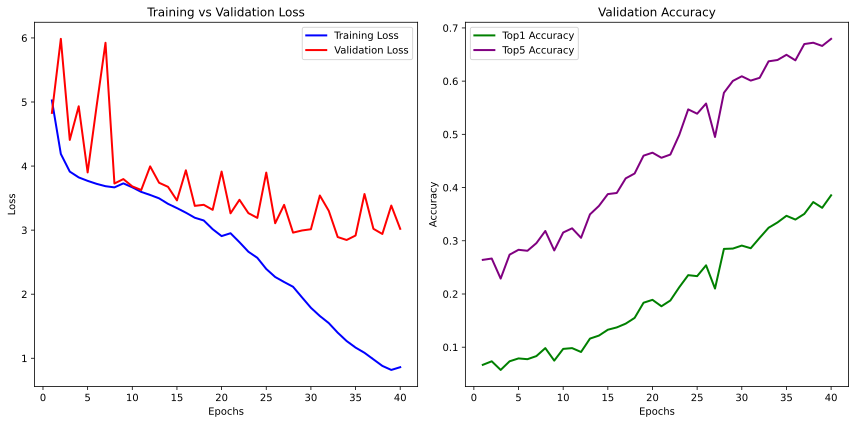

In [170]:
# Plotting the training and validation loss/accuracy curves

# Reading the saved values from the text file
train_losses = read_from_file("train_losses.txt")
val_losses = read_from_file("val_losses.txt")
top1_accuracies = read_from_file("top1_accuracies.txt")
top5_accuracies = read_from_file("top5_accuracies.txt")

epochs_range = range(1, len(train_losses) + 1)

# Plotting loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss", color='blue')
plt.plot(epochs_range, val_losses, label="Validation Loss", color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, top1_accuracies, label="Top1 Accuracy", color='green')
plt.plot(epochs_range, top5_accuracies, label="Top5 Accuracy", color='purple')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

MODELS_NUM = 431
MAKE_NUM = 163
car_make_bool = True   ## TODO Remove this line
pretr_checkpoint_name = "checkpoint.pth.tar"
pretr_checkpoint_path = os.path.join(DATA_PATH, pretr_checkpoint_name)

# Function to save the checkpoint
def save_checkpoint(state, filename):
    torch.save(state, filename)

# Function to load the checkpoint
def load_checkpoint(model, optimizer, scheduler, filename):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        print(f"Loaded checkpoint '{filename}' (epoch {epoch})")
        return model, optimizer, scheduler, epoch, best_acc
    else:
        print(f"No checkpoint found at '{filename}'")
        return model, optimizer, scheduler, 0, 0.0


# Function to calculate the accuracy of the model
def accuracy(outputs, labels):
	_, preds = torch.max(outputs, dim=1)   # Get the prediction label for the batch
	return torch.tensor(torch.sum(preds == labels).item() / len(preds))  #sees how many predictions are correct in the batch

####TODO Check if the function is correct
# Function to predict the class of an image
def predict_image(image_path, model, transform):
	image = Image.open(image_path).convert("RGB")
	image = transform(image).unsqueeze(0).to(device)
	outputs = model(image)
	_, preds = torch.max(outputs, 1)
	return preds.item()


In [117]:
###############################
# load previous save model
###############################

import torchvision.models as models

# Load the model
flag = False

if flag:
	# Load the model if it exists
	if os.path.exists(checkpoint_path):
		model.load_state_dict(torch.load(checkpoint_path))
		print("Model not pretrained successfully!")

else:
	# Load the model
	model = models.resnet50()
	num_ftrs = model.fc.in_features
	model.fc = nnpo.Linear(num_ftrs, MAKE_NUM)  # Adjust the final layer to match the number of classes
	# Define the optimizer
	optimizer = optim.Adam(model.parameters(), lr=0.001)
	scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
	model, opt, scheduler, start_epoch, best_acc = load_checkpoint(model, optimizer, scheduler, pretr_checkpoint_path)
	print("Model pretrained successfully!")

model.eval()

Loading checkpoint '.\Deep_Project\data\checkpoint.pth.tar'


C:\Users\giuse\AppData\Local\Temp\ipykernel_49380\4172017892.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Loaded checkpoint '.\Deep_Project\data\checkpoint.pth.tar' (epoch 11)
Model pretrained successfully!


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

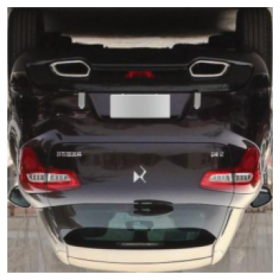

Make: 4
Model: 509
('DS', 'DS 5')
Prediction: 111 ('Volvo', 'Noble M12')


In [138]:
# Predict the class of an image
image_path = os.path.join(test_dir, random.choice(os.listdir(test_dir)))

# Load the image
random_number = random.randint(0, len(train_dataset))
img, car_make, car_model = train_dataset[random_number]
img = denormalize(img.clone(), mean, std)
imshow(img)
print("Make:", car_make)
print("Model:", car_model)

print(get_names(mat_file, [car_make, car_model]))

# Predict the class of the image
img = img.unsqueeze(0).to(device)  # Add a batch dimension and move the image to the device
model.to(device)  # Ensure the model is on the same device as the input
pred = model(img).argmax(dim=1).item()
print("Prediction:", pred, get_names(mat_file, [pred, 0]))